### GRABCUT:

### We take the input image and bounding box and find the unary and binary energies of the pixels and form a graph with these as the edges and then perform a mincut to get the fore gorund and back ground partitions. This is repeated iteratively till convergence. And final segmented fore ground output is shown.
### The above procedure is modularly implemented in the following helper functions and main grabcut function. The comparisions are at the end of the notebook.

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn import mixture
import math
import maxflow

In [4]:
def read_img_bbox(filename,ext,user= False):
    img=plt.imread("./data/images/"+str(filename)+"."+str(ext))
    if user==False:
        bbox=np.loadtxt("./data/bboxes/"+str(filename)+".txt",delimiter=" ")
    elif user == True:
        r = cv2.selectROI(img,False,False)
        cv2.destroyAllWindows()
        bbox=np.array([r[0],r[1],r[0]+r[2],r[1]+r[3]]) 
    return img,bbox

In [5]:
def instantiate_graph(img,neigh_count):
    node_count = img.shape[0]*img.shape[1]+2
    nonterminal_nodes = node_count-2
    edge_count = (node_count-2)*neigh_count + 2*nonterminal_nodes
    G = maxflow.Graph[float](node_count,edge_count)
    G.add_nodes(nonterminal_nodes)
    return G

In [37]:
def plot_images(img,fore_unsegmented,fore_segmented):
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(20,20))
    # fig.suptitle('Horizontally stacked subplots')
    ax1.set_title("Original Image")
    ax1.imshow(img)
    ax2.set_title("Cropped Image")
    ax2.imshow(fore_unsegmented)
    ax3.set_title("Segmented Image")
    ax3.imshow(fore_segmented)
    plt.show()

In [7]:
def find_adj(row,col,img):
    height,width,channels=img.shape
    adj = []
    if row < height - 1:
        adj.append([row+1,col])
    if col < width -1:
        adj.append([row,col+1])
    return adj

In [8]:
def compute_beta(img):
    height,width,channels=img.shape
    cons_sum=0
    count=0
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            adjacent = find_adj(row,col,img)
            for vertices in adjacent:
                cons_sum+=sum((img[row,col]-img[vertices[0],vertices[1]])**2)
                count+=1
    beta = 1.00/(2*cons_sum/count)
    return beta

In [61]:
def fill_graph(G,fore_unaries,back_unaries,img,beta,alpha):
    height,width,channels=img.shape
#     x_low, y_low, x_high, y_high = bbox
    fore_costs=fore_unaries
    fore_costs=np.reshape(fore_costs,(fore_costs.shape[0]*fore_costs.shape[1]))    
    back_costs=back_unaries
    back_costs=np.reshape(back_costs,(back_costs.shape[0]*back_costs.shape[1]))
    gamma=100
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            ind = row*img.shape[1] + col
#             if (col >= x_low) and (row >= y_low) and (col <= x_high) and (row <= y_high):
            if alpha[row,col]==1:
                w1 = fore_costs[ind]
                w2 = back_costs[ind]
            else:
                w1 = 1e8
                w2 = 0
            G.add_tedge(ind,w1,w2)
            adjacent = find_adj(row,col,img)
            for vertices in adjacent:
                new_ind= vertices[0]*img.shape[1] + vertices[1]
                sqr=sum((img[row,col]-img[vertices[0],vertices[1]])**2)
                ######---binary-energies---######
                binary_cost = gamma*math.exp(-1*beta*sqr)   
                G.add_edge(ind,new_ind,binary_cost,binary_cost)
                
    return G

In [25]:
def compute_unary_energy(alpha,gmm,img,bbox):
    height,width,channels=img.shape
    x_low, y_low, x_high, y_high = bbox
    weights = gmm.weights_
    means = gmm.means_
    covariances = gmm.covariances_
    prob_mask=np.zeros((height,width))
    idx = gmm.predict(img.reshape(img.shape[0]*img.shape[1],3)).reshape(img.shape[:2])
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
#             if (col >= x_low) and (row >= y_low) and (col <= x_high) and (row <= y_high):
            if alpha[row,col]==1:
                index = idx[row,col]
                pi = weights[index]
                mean = means[index]
                cov_mat = covariances[index]
                cov_det = np.linalg.det(cov_mat)
                cov_inv = np.linalg.inv(cov_mat)
                #root_det
                D = -math.log(pi)+0.5*math.log(cov_det)+0.5*np.dot(np.dot((img[row,col]-mean).T,cov_inv),(img[row,col]-mean))
                prob_mask[row,col]=max(D,0)
    return prob_mask

In [26]:
def gmm_partitions(points,num_components=5):
    gmm=mixture.GaussianMixture(n_components=num_components,covariance_type='full')
    gmm.fit(points)
    return gmm

In [47]:
def initial_dist(img,bbox,num_comps=5):
    x_low, y_low, x_high, y_high = bbox
    alpha = np.zeros((img.shape[0],img.shape[1]), dtype=np.int8)
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            if (col >= x_low) and (row >= y_low) and (col <= x_high) and (row <= y_high):
                alpha[row,col] = 1
    foreground=img[alpha==1]
    background=img[alpha==0]
#     print(foreground.shape[0]+background.shape[0])
#     print(img.shape[0]*img.shape[1])
    fore_gmm = gmm_partitions(foreground,num_comps)
    back_gmm = gmm_partitions(background,num_comps)
    return alpha,fore_gmm,back_gmm

In [48]:
def update_dist(img,bbox,alpha,num_comps=5):
    foreground=img[alpha==1]
    background=img[alpha==0]
#     print(foreground.shape[0]+background.shape[0])
#     print(img.shape[0]*img.shape[1])
    fore_gmm = gmm_partitions(foreground,num_comps)
    back_gmm = gmm_partitions(background,num_comps)
    return fore_gmm,back_gmm

In [49]:
def grabcut(img,bbox,num_iters=1,num_neighs=4,num_comps=5):
    beta = compute_beta(img) 
    
    for i in range(num_iters):
        if i==0:
#             print("Running iteration:",i+1)
            alpha,fore_gmm,back_gmm = initial_dist(img,bbox,num_comps)
            bound = alpha
        else:
#             print("Running iteration:",i+1)
            fore_gmm,back_gmm = update_dist(img,bbox,alpha3,num_comps)
            alpha = alpha3
        fore_unaries = compute_unary_energy(alpha,fore_gmm,img,bbox)
        back_unaries = compute_unary_energy(alpha,back_gmm,img,bbox)
        G = instantiate_graph(img,num_neighs)
        G=fill_graph(G,fore_unaries,back_unaries,img,beta,alpha)
        G.maxflow()
        partition = G.get_grid_segments(np.arange(img.shape[0]*img.shape[1]))
        partition = partition.reshape(alpha.shape).astype(np.uint8)
        alpha3 = partition
#         print("Finished iteration:",i+1)
    print("Number of iterations:",num_iters)
    return alpha3,bound

In [50]:
def compute_results(img,bbox,num_iterations=1,num_comps=5):
    alpha_final,bound = grabcut(img,bbox,num_iterations,4,num_comps)
    fore_segmented = np.stack((alpha_final,alpha_final,alpha_final),axis=2)*img
    fore_unsegmented = np.stack((bound,bound,bound),axis=2)*img
    return fore_segmented,fore_unsegmented

In [107]:
####------------ Example-1:
img1,bbox1 = read_img_bbox("flower","jpg")

In [87]:
alpha31,bound1 = grabcut(img1,bbox1,2,4)
fore_segmented1 = np.stack((alpha31,alpha31,alpha31),axis=2)*img1
fore_unsegmented1 = np.stack((bound1,bound1,bound1),axis=2)*img1

Running iteration: 1
Finished iteration: 1
Running iteration: 2
Finished iteration: 2


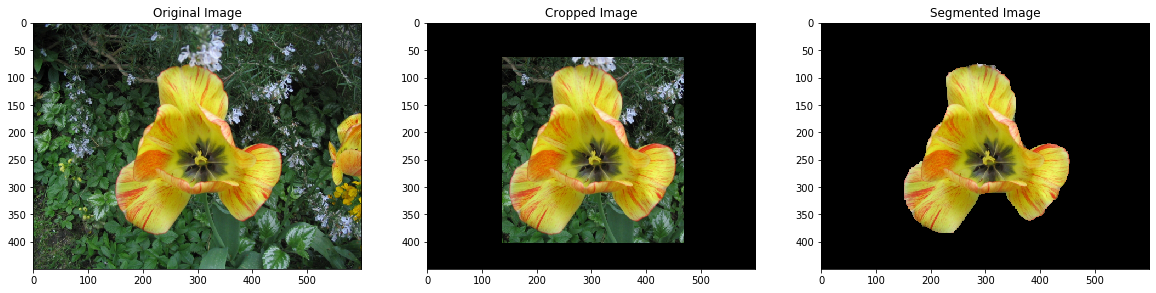

In [106]:
plot_images(img1,fore_unsegmented1,fore_segmented1)

In [89]:
####------------ Example-2:
img2,bbox2 = read_img_bbox("person2","jpg")

In [91]:
alpha32,bound2 = grabcut(img2,bbox2,3,4)
fore_segmented2 = np.stack((alpha32,alpha32,alpha32),axis=2)*img2
fore_unsegmented2 = np.stack((bound2,bound2,bound2),axis=2)*img2

Running iteration: 1
Finished iteration: 1
Running iteration: 2
Finished iteration: 2
Running iteration: 3
Finished iteration: 3


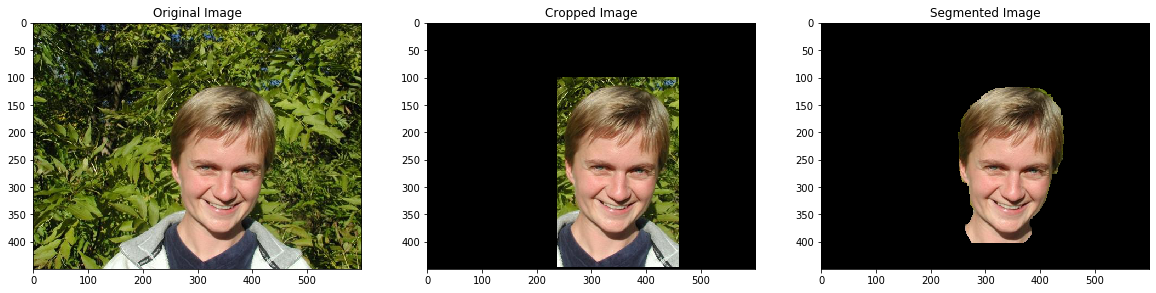

In [105]:
plot_images(img2,fore_unsegmented2,fore_segmented2)

### Varying no. of iterations:

####  It can be observed from the following examples that increasing the number of iterations gives better results upto a point.After which important info can be lost.

In [20]:
####------------ Example-3:
img3,bbox3 = read_img_bbox("person1","jpg",user=False)

Number of iterations: 1


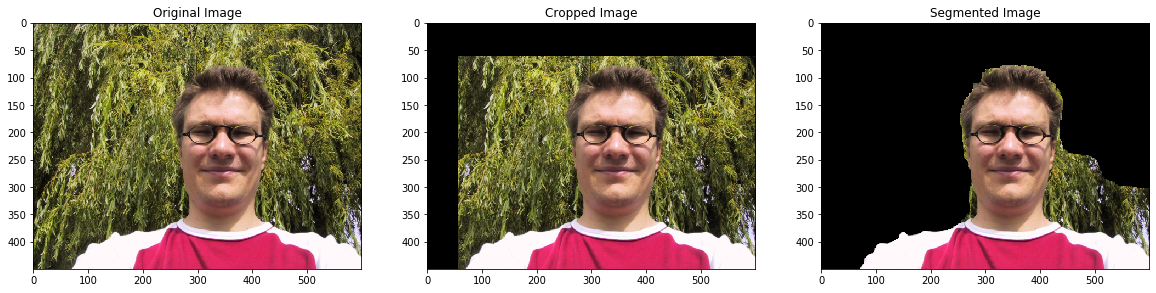

Number of iterations: 3


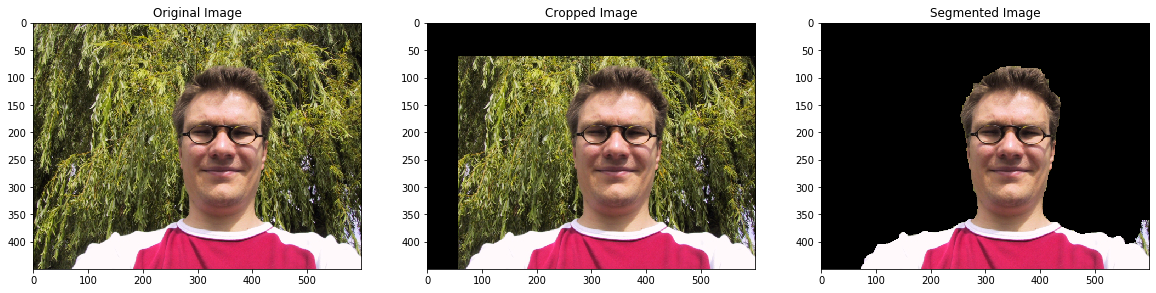

Number of iterations: 6


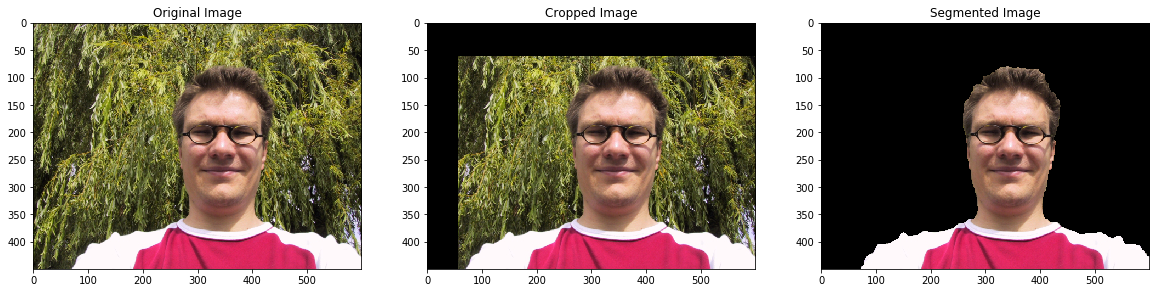

In [39]:
#### iter=1
fore_segmented3,fore_unsegmented3 = compute_results(img3,bbox3,1)
plot_images(img3,fore_unsegmented3,fore_segmented3)
#### iter=3
fore_segmented3,fore_unsegmented3 = compute_results(img3,bbox3,3)
plot_images(img3,fore_unsegmented3,fore_segmented3)
#### iter=6
fore_segmented3,fore_unsegmented3 = compute_results(img3,bbox3,6)
plot_images(img3,fore_unsegmented3,fore_segmented3)

In [41]:
####------------ Example-4:
img4,bbox4 = read_img_bbox("sheep","jpg",user=False)

Number of iterations: 1


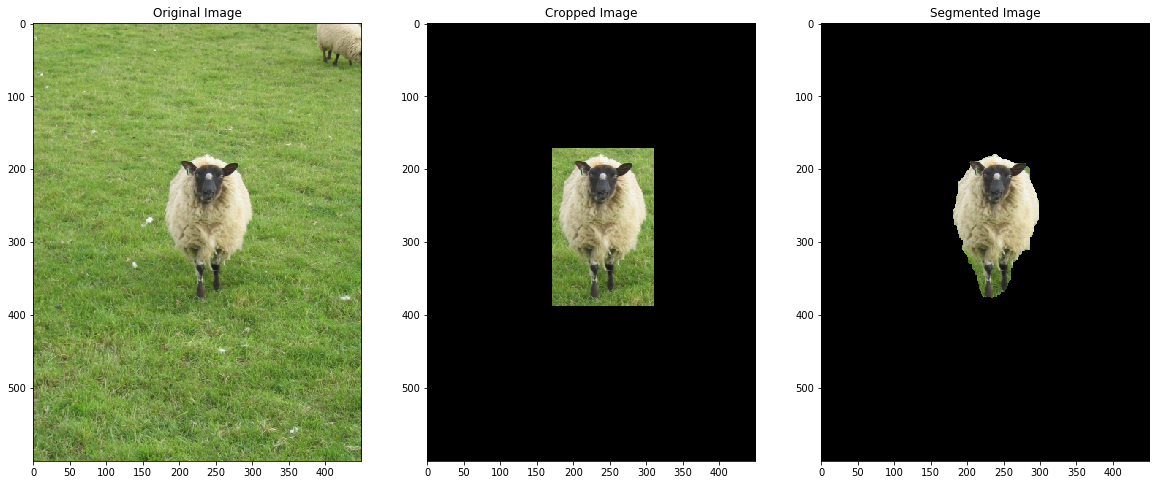

Number of iterations: 3


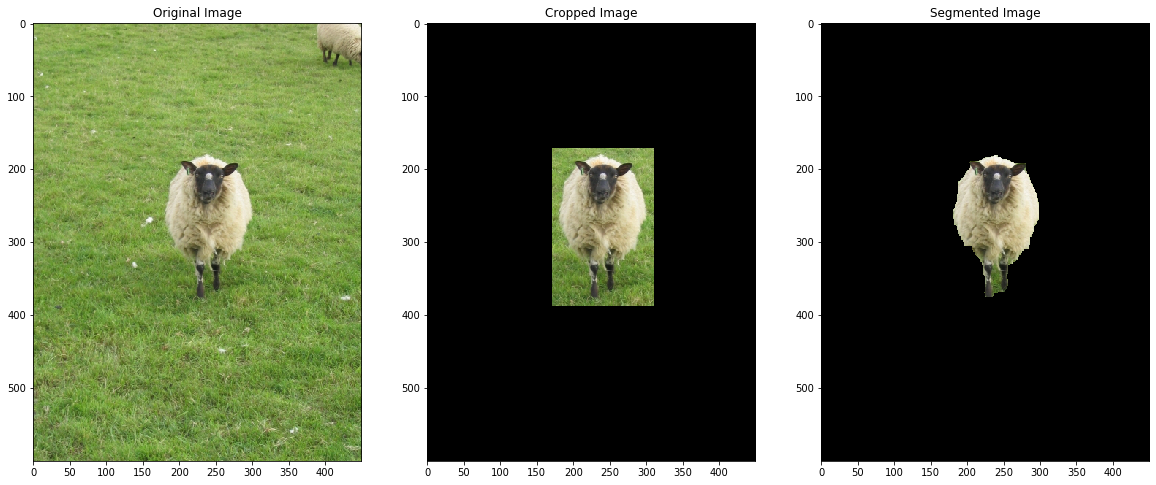

Number of iterations: 8


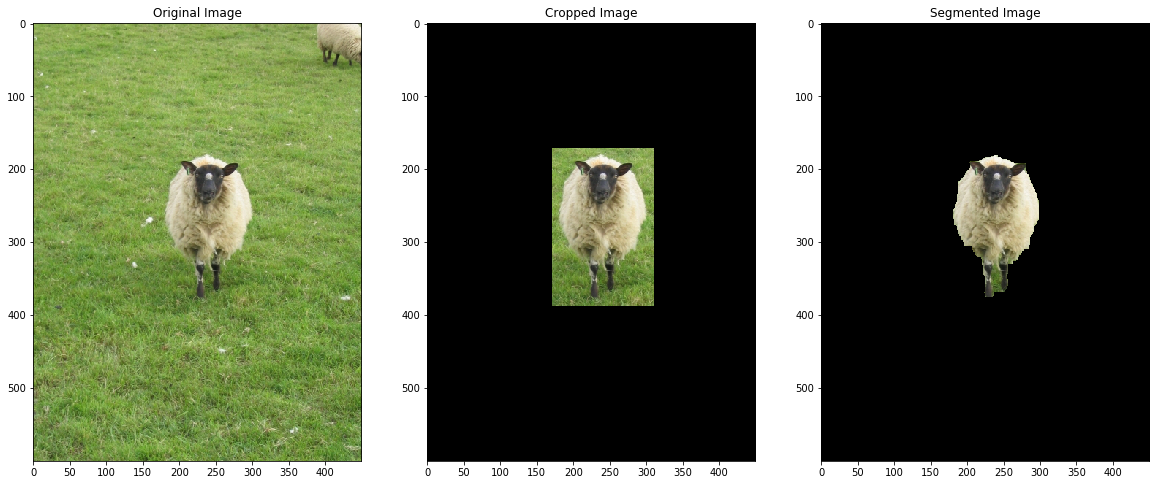

In [43]:
#### iter=1
fore_segmented4,fore_unsegmented4 = compute_results(img4,bbox4,1)
plot_images(img4,fore_unsegmented4,fore_segmented4)
#### iter=3
fore_segmented4,fore_unsegmented4 = compute_results(img4,bbox4,3)
plot_images(img4,fore_unsegmented4,fore_segmented4)
#### iter=8
fore_segmented4,fore_unsegmented4 = compute_results(img4,bbox4,8)
plot_images(img4,fore_unsegmented4,fore_segmented4)

### Varying num. of components in GMM:


In [53]:
####------------ Example-5:
img5,bbox5 = read_img_bbox("doll","jpg",user=False)

Number of iterations: 3


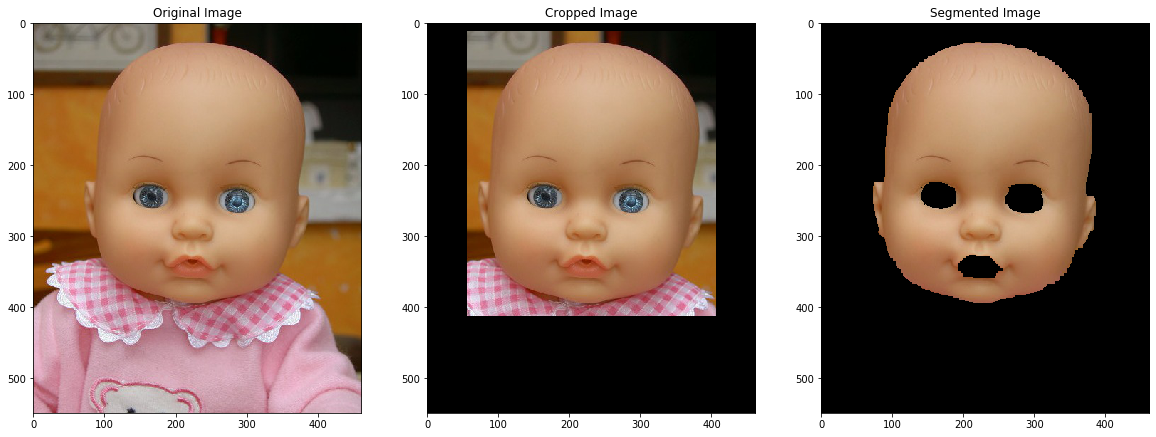

Number of iterations: 3


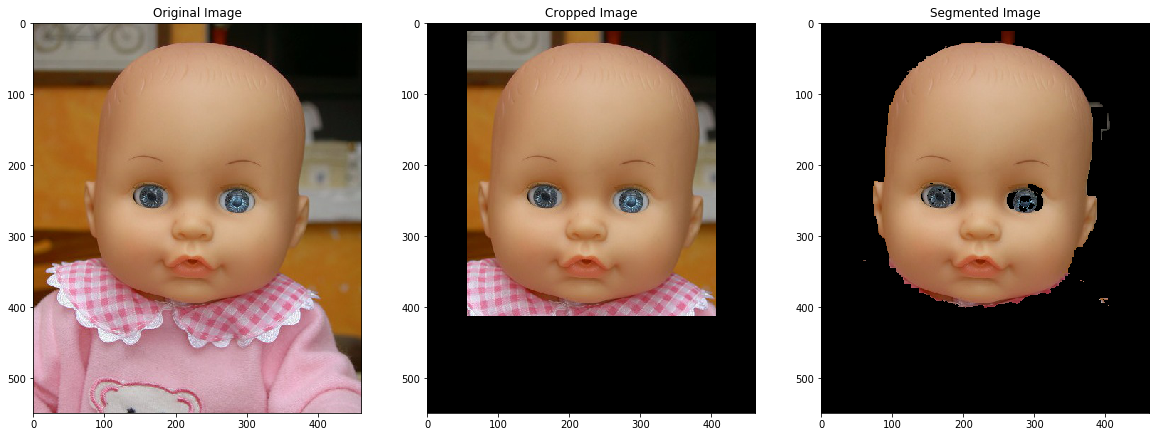

Number of iterations: 3


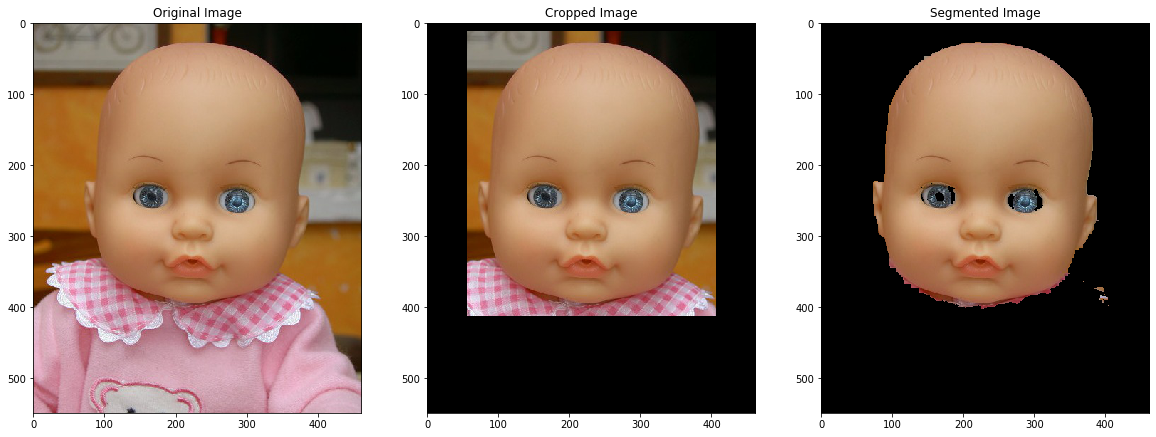

In [51]:
#### num_comps = 1
fore_segmented5,fore_unsegmented5 = compute_results(img5,bbox5,3,1)
plot_images(img5,fore_unsegmented5,fore_segmented5)
#### num_comps = 3
fore_segmented5,fore_unsegmented5 = compute_results(img5,bbox5,3,3)
plot_images(img5,fore_unsegmented5,fore_segmented5)
#### num_comps = 5
fore_segmented5,fore_unsegmented5 = compute_results(img5,bbox5,3,5)
plot_images(img5,fore_unsegmented5,fore_segmented5)

In [55]:
####------------ Example-6:
img6,bbox6 = read_img_bbox("llama","jpg",user=False)

Number of iterations: 5
Number of GMM components: 1


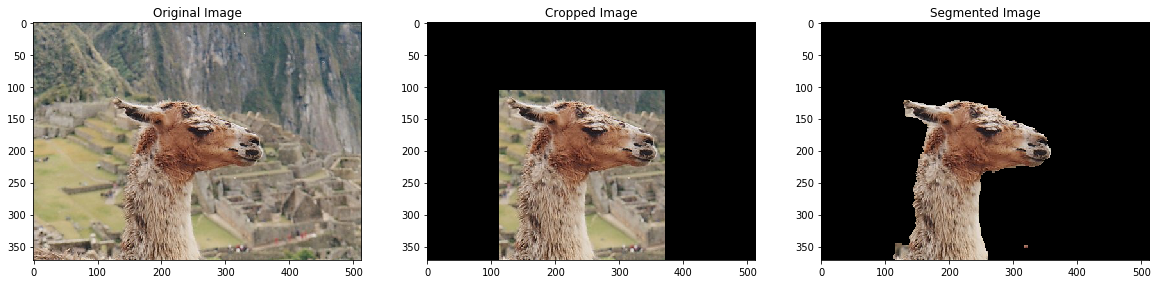

Number of iterations: 5
Number of GMM components: 3


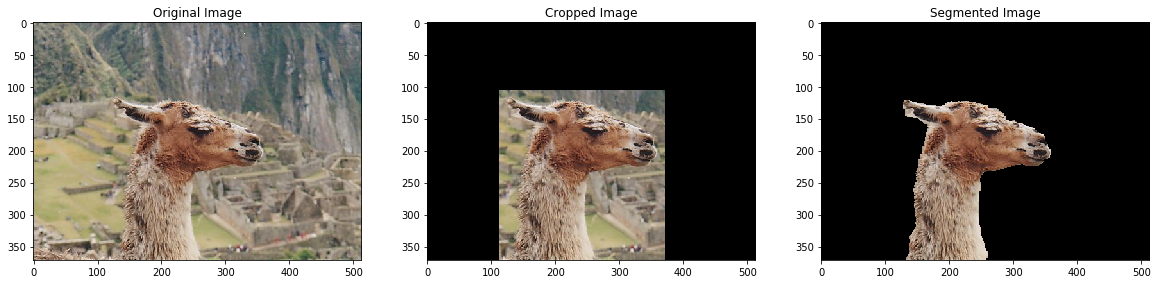

Number of iterations: 5
Number of GMM components: 5


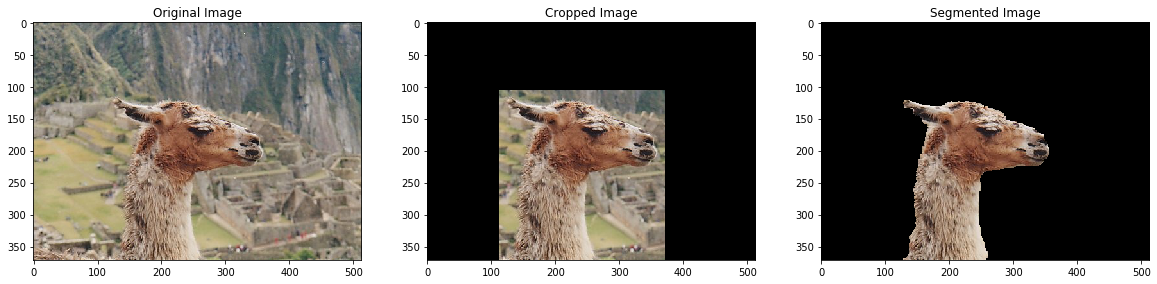

In [56]:
#### num_comps = 1
fore_segmented6,fore_unsegmented6 = compute_results(img6,bbox6,5,1)
print("Number of GMM components: 1")
plot_images(img6,fore_unsegmented6,fore_segmented6)
#### num_comps = 3
fore_segmented6,fore_unsegmented6 = compute_results(img6,bbox6,5,3)
print("Number of GMM components: 3")
plot_images(img6,fore_unsegmented6,fore_segmented6)
#### num_comps = 5
fore_segmented6,fore_unsegmented6 = compute_results(img6,bbox6,5,5)
print("Number of GMM components: 5")
plot_images(img6,fore_unsegmented6,fore_segmented6)

### Varying Gamma:
#### High gamma means that high weightage is being given for a pair to belong to the same class,  so in some cases it might take more number of iterations to segment the foreground as compared to lower gamma. Good gamma ~ 50

#### Gamma=50

In [58]:
####------------ Example-7:
img7,bbox7 = read_img_bbox("person3","jpg",user=False)

Number of iterations: 5


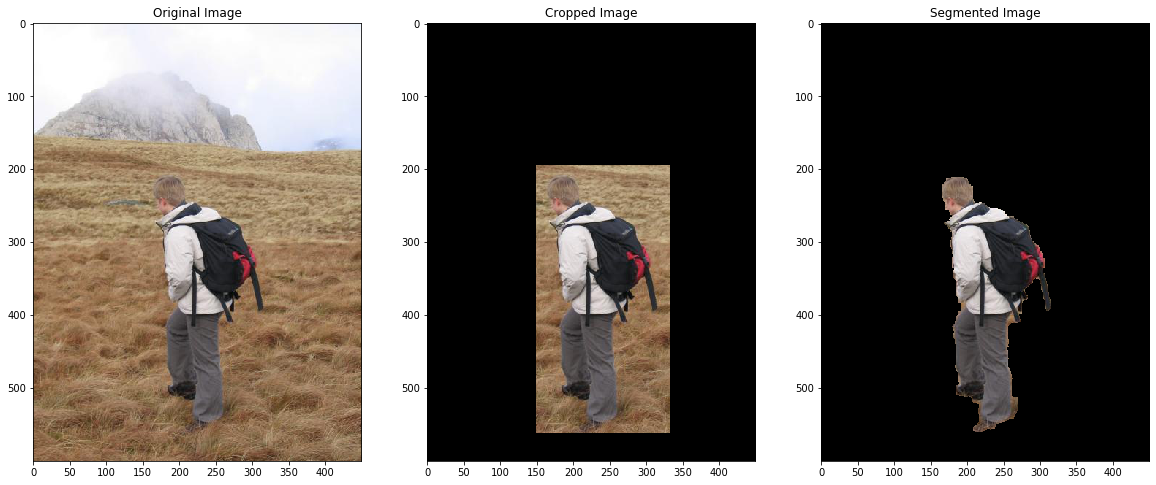

In [59]:
#### num_comps = 5
fore_segmented7,fore_unsegmented7 = compute_results(img7,bbox7,5,5)
# print("Number of GMM components: 5")
plot_images(img7,fore_unsegmented7,fore_segmented7)

#### Gamma=100

Number of iterations: 5
gamma: 100


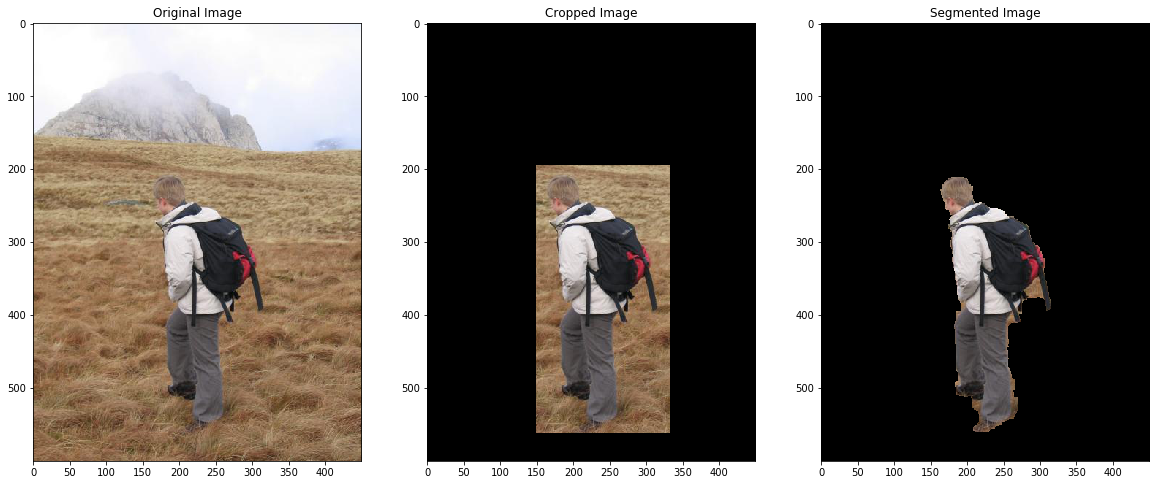

In [62]:
### num_comps = 5
fore_segmented7,fore_unsegmented7 = compute_results(img7,bbox7,5,5)
print("gamma: 100")
plot_images(img7,fore_unsegmented7,fore_segmented7)

### Choosing beta:
#### Beta can alternatively be chosen such that the pair wise energy is high when 2 pixels are not similar (zm~zn>>0) and around 1 other wise.

### Connectivity:
#### For high connectivity (say 8-neighbourhood), we consider binary eneries between more number of neighbours and hence while performing the mincut, we might get rough uneven edges in the initial iterations, we get good results after more no. of iterations.

### Bounding box:
#### A tight bounding box gives better results compared to a loose bounding box as there is more certainity about a large no of background pixels (like in above cases) and hence weights can given based on that, so as to get quicker, better and more certain results 

### Color spaces:
#### In some cases changing to HSV or YCrCb etc., can give better results when there are more number of similar bg and fg RGB pixels, like in the case of banana.jpg and elefant.jpg